# GAN

In [1]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

### Load images

In [2]:
input_images = './quickdraw_data/apple.npy'

In [3]:
data = np.load(input_images)

In [4]:
data.shape

(144722, 784)

In [5]:
data[7541]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   2,  43,  86,  91,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  38, 200, 255, 255, 227,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  99, 244, 231,  97,
        39,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  12, 170, 255, 180,
        50,  51,  56,  35,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  89, 193, 221, 219, 113,   0, 16

In [6]:
data = data/255
data = np.reshape(data, (data.shape[0],28,28,1))
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [7]:
data[7541]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

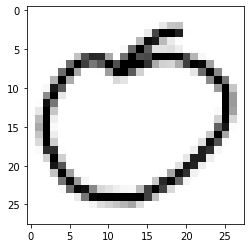

In [8]:
plt.imshow(data[7541,:,:,0], cmap='Greys')

### Discriminator Network

In [9]:
def discriminator_builder(width = 64, p = 0.4):
    
    # define inputs
    
    inputs = keras.layers.Input((img_w, img_h,1))
    
    # convolutional layers
    conv1 = keras.layers.Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = keras.layers.Dropout(p)(conv1)
    
    conv2 = keras.layers.Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = keras.layers.Dropout(p)(conv2)
    
    conv3 = keras.layers.Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = keras.layers.Dropout(p)(conv3)
    
    conv4 = keras.layers.Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = keras.layers.Flatten()(keras.layers.Dropout(p)(conv4))
    
    output = keras.layers.Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

In [ ]:
discriminator = discriminator_builder()

In [ ]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=keras.optimizers.RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])

### Generator Network

In [ ]:
def generator_builder(z_dim=100,width=64,p=0.4):
    
    # Define inputs
    inputs = keras.layers.Input((z_dim,))
    
    # First dense layer
    dense1 = keras.layers.Dense(7*7*64)(inputs)
    dense1 = keras.layers.BatchNormalization(momentum = 0.9)(dense1)
    dense1 = keras.layers.Activation(activation = 'relu')(dense1)
    dense1 = keras.layers.Reshape((7,7,64))(dense1)
    dense1 = keras.layers.Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = keras.layers.UpSampling2D()(dense1)
    conv1 = keras.layers.Conv2DTranspose(int(width / 2), kernel_size = 5, padding = 'same', activation = None,)(conv1)
    conv1 = keras.layers.BatchNormalization(momentum=0.9)(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    
    conv2 = keras.layers.UpSampling2D()(conv1)
    conv2 = keras.layers.Conv2DTranspose(int(width / 4), kernel_size = 5, padding = 'same', activation = None,)(conv2)
    conv2 = keras.layers.BatchNormalization(momentum=0.9)(conv2)
    conv2 = keras.layers.Activation(activation='relu')(conv2)
    
    conv3 = keras.layers.Conv2DTranspose(int(width / 8), kernel_size = 5, padding = 'same', activation = None,)(conv2)
    conv3 = keras.layers.BatchNormalization(momentum=0.9)(conv3)
    conv3 = keras.layers.Activation(activation='relu')(conv3)
    
    output = keras.layers.Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model


In [ ]:
generator = generator_builder()

### Create adversarial network¶

In [ ]:
def adversarial_builder(z_dim=100):
    model = keras.models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
adversarial_model = adversarial_builder()

### Train

In [ ]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [ ]:
def train(epochs=2000,batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

In [ ]:
a_metrics_complete, d_metrics_complete = train(epochs=3000)